In [38]:
import numpy as np
import spacy
import random
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from termcolor import colored

In [39]:
# Dirichlet hyperparameters
ALPHA = 0.1  # Document-topic Dirichlet prior
BETA = 0.1   # Topic-word Dirichlet prior
NUM_TOPICS = 20
ITERATIONS = 200

In [40]:
sp = spacy.load("en_core_web_sm")

In [41]:
np.random.seed(42)
random.seed(42)

In [42]:
def load_data(train_csv_path, test_csv_path=None):
    train_df = pd.read_csv(train_csv_path)
    train_df['text'] = train_df['TITLE'] + ' ' + train_df['ABSTRACT']
    test_df = None
    if test_csv_path:
        test_df = pd.read_csv(test_csv_path)
        test_df['text'] = test_df['TITLE'] + ' ' + test_df['ABSTRACT']
    
    return train_df, test_df

In [43]:
def generate_frequencies(data, max_docs=10000):
    #Generating word frequencies from documents
    freqs = Counter()
    all_stopwords = sp.Defaults.stop_words
    nr_tokens = 0

    for doc in data[:max_docs]:
        if isinstance(doc, str):
            tokens = sp.tokenizer(doc)
            for token in tokens:
                token_text = token.text.lower()
                if token_text not in all_stopwords and token.is_alpha and len(token_text) > 2:
                    nr_tokens += 1
                    freqs[token_text] += 1
    
    print(f"Total tokens before filtering: {nr_tokens}")
    print(f"Unique words before filtering: {len(freqs)}")
    return freqs

In [44]:
def get_vocab(freqs, freq_threshold=3):
    #Building vocabulary from word frequencies
    vocab = {}
    vocab_idx_str = {}
    vocab_idx = 0

    for word in freqs:
        if freqs[word] >= freq_threshold:
            vocab[word] = vocab_idx
            vocab_idx_str[vocab_idx] = word
            vocab_idx += 1
    
    print(f"Vocabulary size after filtering: {len(vocab)}")
    return vocab, vocab_idx_str

In [45]:
def tokenize_dataset(data, vocab, max_docs=10000):
    #Tokenizing and numericalize documents
    nr_tokens = 0
    nr_docs = 0
    docs = []
    corpus = []
    processed_docs = []

    for doc in data[:max_docs]:
        if not isinstance(doc, str):
            continue
            
        tokens = sp.tokenizer(doc)
        doc_tokens = []
        corpus_d = []

        for token in tokens:
            token_text = token.text.lower()
            if token_text in vocab:
                doc_tokens.append(token_text)
                corpus_d.append(vocab[token_text])
                nr_tokens += 1
        
        if len(doc_tokens) > 1:  # Only keeping documents with at least 2 tokens
            docs.append(doc_tokens)
            corpus.append(np.asarray(corpus_d))
            processed_docs.append(doc)
            nr_docs += 1

    print(f"Number of documents after processing: {nr_docs}")
    print(f"Number of tokens after processing: {nr_tokens}")
    return docs, corpus, processed_docs

In [47]:
def LDA_collapsed_Gibbs(corpus, vocab_size, num_topics=NUM_TOPICS, num_iter=ITERATIONS):
    #Implementing LDA using collapsed Gibbs sampling
    # Initializing counts and Z
    Z = []
    num_docs = len(corpus)
    
    for doc_idx, doc in enumerate(corpus):
        Zd = np.random.randint(low=0, high=num_topics, size=len(doc))
        Z.append(Zd)
    
    ndk = np.zeros((num_docs, num_topics))  # document-topic counts
    for d in range(num_docs):
        for k in range(num_topics):
            ndk[d, k] = np.sum(Z[d] == k)
    
    nkw = np.zeros((num_topics, vocab_size))  # topic-word counts
    for doc_idx, doc in enumerate(corpus):
        for i, word in enumerate(doc):
            topic = Z[doc_idx][i]
            nkw[topic, word] += 1
    
    nk = np.sum(nkw, axis=1)  # topic counts
    topic_list = list(range(num_topics))
    
    # Gibbs sampling iterations
    print("Starting Gibbs sampling iterations...")
    for iteration in tqdm(range(num_iter)):
        for doc_idx, doc in enumerate(corpus):
            for i in range(len(doc)):
                word = doc[i]
                topic = Z[doc_idx][i]
                
                # Removing current assignment
                ndk[doc_idx, topic] -= 1
                nkw[topic, word] -= 1
                nk[topic] -= 1
                
                # Sampling a new topic
                p_z = (ndk[doc_idx, :] + ALPHA) * (nkw[:, word] + BETA) / (nk[:] + BETA * vocab_size)
                
                # Normalizing the probabilities
                p_z = p_z / np.sum(p_z)
                
                topic = random.choices(topic_list, weights=p_z, k=1)[0]
                
                # Updating counts with new assignment
                Z[doc_idx][i] = topic
                ndk[doc_idx, topic] += 1
                nkw[topic, word] += 1
                nk[topic] += 1
        
        if (iteration + 1) % 10 == 0:
            print(f"Completed iteration {iteration + 1}/{num_iter}")
    
    return Z, ndk, nkw, nk

In [15]:
def calculate_perplexity(nkw, nk, ndk, alpha, beta, corpus, vocab_size):    #Calculating the perplexity for held-out documents
    log_likelihood = 0
    total_words = 0
    
    phi = (nkw + beta) / (nk.reshape(NUM_TOPICS, 1) + beta * vocab_size)     # Calculating phi (topic-word distribution)
    
    theta = (ndk + alpha) / (np.sum(ndk, axis=1).reshape(-1, 1) + alpha * NUM_TOPICS)     # Calculating the theta (document-topic distribution)
    
    for d, doc in enumerate(corpus):
        for word in doc:
            word_prob = 0
            for k in range(NUM_TOPICS):
                word_prob += theta[d, k] * phi[k, word]
            log_likelihood += np.log(word_prob)
            total_words += 1
    
    perplexity = np.exp(-log_likelihood / total_words)
    return perplexity

In [48]:
def infer_topics_for_test(test_corpus, nkw, nk, alpha, beta, vocab_size, num_iter=50):     #Infering topics for new documents (test set)
    num_docs = len(test_corpus)
    Z_test = []     # Initializing topic assignments randomly for test documents
    for doc in test_corpus:
        Z_test.append(np.random.randint(low=0, high=NUM_TOPICS, size=len(doc)))
    
    ndk_test = np.zeros((num_docs, NUM_TOPICS))
    for d in range(num_docs):
        for k in range(NUM_TOPICS):
            ndk_test[d, k] = np.sum(Z_test[d] == k)
    
    phi = (nkw + beta) / (nk.reshape(NUM_TOPICS, 1) + beta * vocab_size)
    
    topic_list = list(range(NUM_TOPICS))
    
    print("Inferring topics for test documents...")
    for iteration in tqdm(range(num_iter)):
        for doc_idx, doc in enumerate(test_corpus):
            for i in range(len(doc)):
                word = doc[i]
                topic = Z_test[doc_idx][i]
                
                ndk_test[doc_idx, topic] -= 1   # Removing the current assignment
            
                p_z = (ndk_test[doc_idx, :] + alpha) * phi[:, word]   # Sampling new topic
                
                p_z = p_z / np.sum(p_z)  # Normalizing probabilities
                
                topic = random.choices(topic_list, weights=p_z, k=1)[0]
                
                Z_test[doc_idx][i] = topic
                ndk_test[doc_idx, topic] += 1

    theta_test = (ndk_test + alpha) / (np.sum(ndk_test, axis=1).reshape(-1, 1) + alpha * NUM_TOPICS)      # Calculatingdocument-topic distribution for test docs
    
    return Z_test, theta_test, ndk_test

In [49]:
def print_top_words_per_topic(nkw, nk, vocab_idx_str, num_words=10):
    phi = nkw / nk.reshape(NUM_TOPICS, 1) # Calculating phi (topic-word distribution)
    
    for k in range(NUM_TOPICS):
        most_common_words = np.argsort(phi[k])[::-1][:num_words]
        print(f"\nTopic {k} most common words:")
        for i, word_idx in enumerate(most_common_words):
            if word_idx in vocab_idx_str:
                print(f"{i+1}. {vocab_idx_str[word_idx]}")
            else:
                print(f"{i+1}. <unknown>")

In [50]:
def print_top_topics_per_doc(ndk, docs_text, num_docs=5, num_topics=3):
   
    theta = ndk / np.sum(ndk, axis=1).reshape(-1, 1)   # Calculating theta (document-topic distribution)
     
    # Sample documents to display
    sample_idxs = np.random.choice(len(docs_text), min(num_docs, len(docs_text)), replace=False)
    
    for idx in sample_idxs:
        top_topics = np.argsort(theta[idx])[::-1][:num_topics]
        print(f"\nDocument excerpt: {docs_text[idx][:100]}...")
        print("Top topics:")
        for i, topic_idx in enumerate(top_topics):
            print(f"{i+1}. Topic {topic_idx} (probability: {theta[idx, topic_idx]:.4f})")

In [51]:
def analyze_category_topic_distribution(topics_distribution, categories_data):
    categories = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 
                  'Quantitative Biology', 'Quantitative Finance']
    
    category_topic_counts = {}
    for category_idx, category in enumerate(categories):
        category_docs = [i for i, row in enumerate(categories_data) if row[category_idx] == 1]
        
        if category_docs:
            category_topics = topics_distribution[category_docs]  # Getting topic distributions for these docs
            
            dominant_topics = np.argmax(category_topics, axis=1)             # Finding most common topic for each doc
            topic_counts = np.bincount(dominant_topics, minlength=NUM_TOPICS)
            
            topic_percentages = topic_counts / len(category_docs) * 100 #Nrmalizing for percentages
            
            category_topic_counts[category] = topic_percentages
    
    print("\nTopic distribution across paper categories:")
    for category, topic_percentages in category_topic_counts.items():
        print(f"\n{category}:")
        top_topics = np.argsort(topic_percentages)[::-1][:5]  # Top 5 topics
        for topic_idx in top_topics:
            print(f"  Topic {topic_idx}: {topic_percentages[topic_idx]:.2f}%")

In [52]:
def display_word_clouds(nkw, nk, vocab_idx_str, num_topics=20, words_to_display=30):
    phi = nkw / nk.reshape(num_topics, 1)
    
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Purples', 'GnBu', 
                'copper', 'Greys', 'Wistia', 'summer', 'autumn', 'winter', 
                'spring', 'cool', 'hot', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    rows = int(np.ceil(num_topics/2))
    fig, axes = plt.subplots(rows, 2, figsize=(20, 5*rows))
    axes = axes.flatten()
    
    word_df = pd.DataFrame()     # Creating a DataFrame to store top words for each topic
    
    for k in range(num_topics):
        top_indices = np.argsort(phi[k])[:-(words_to_display+1):-1] # Getting the top words for this topic
        
        
        word_freq = {vocab_idx_str[i]: phi[k][i] for i in top_indices} # Creating word frequency dictionary for wordcloud
        
        # Generate and display wordcloud
        wordcloud = WordCloud(background_color='black', 
                              colormap=colormaps[k % len(colormaps)], 
                              prefer_horizontal=1,
                              width=800, height=400)
        wordcloud.generate_from_frequencies(frequencies=word_freq)
        
        # Plot wordcloud
        axes[k].imshow(wordcloud)
        axes[k].axis('off')
        axes[k].set_title(f"Topic {k}")
        
        # Add words to DataFrame
        words = [vocab_idx_str[i] for i in top_indices]
        word_df[f"Topic {k}"] = words
    
    # Hide unused subplots
    for i in range(num_topics, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display table of top words
    return word_df

In [53]:
def visualize_colored_document(doc, Z, vocab_idx_str, num_topics=20):  #Visualizing a document with words colored by their assigned topic

    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 
               'grey', 'white']
    

    print(' '.join([colored(f"Topic {i}", c) for i, c in enumerate(colors[:num_topics])]))     # Printing the color legend
    print()
    

    colored_doc = []     # Printing document with words colored by topic
    for i, word_idx in enumerate(doc):
        if i < len(Z):  # Ensure we have a topic assignment
            topic = Z[i]
            word = vocab_idx_str.get(word_idx, "<UNK>")
            colored_doc.append(colored(word, colors[topic % len(colors)]))
    
    print(' '.join(colored_doc))


In [60]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
    if ax is None:
        ax = plt.gca()
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
     # Handle potential duplicate kwargs by merging them
    ellipse_kwargs = {'alpha': 0.3}
    ellipse_kwargs.update(kwargs)  # This will override alpha if it's in kwargs
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **ellipse_kwargs)
    ax.add_artist(ellip)
    return ellip

In [55]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plot confidence ellipse for a group of points
    """
    if len(points) < 3:
        return None
        
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

In [62]:
def plot_document_topic_clusters(theta, docs_text, num_topics=20, confidence_level=0.3, topic_names=None):#Plotting document clusters based on topic distributions using t-SNE#
    
    if topic_names is None:
        topic_names = [f'Topic {i}' for i in range(num_topics)]
    
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 
              'brown', 'grey', 'yellow', 'olive', 'magenta', 'pink',
              'teal', 'lightblue', 'maroon', 'navy', 'lime', 'coral',
              'gold', 'silver']
    
    doc_topics = np.argmax(theta, axis=1) # Getting the dominant topic for each document
    doc_topic_probs = np.max(theta, axis=1)
    
    high_conf_indices = np.where(doc_topic_probs > confidence_level)[0]  # Filtering documents with high confidence
    if len(high_conf_indices) < 10:
        high_conf_indices = np.argsort(doc_topic_probs)[-100:]  # Taking the top 100 if too few
    
    print(f"Number of high confidence documents: {len(high_conf_indices)}")
    
    doc_colors = [colors[doc_topics[i] % len(colors)] for i in high_conf_indices]     # Getting document colors based on dominant topic
    
    doc_features = theta[high_conf_indices]     # Creating document features for t-SNE
    
    tsne = TSNE(n_components=2, perplexity=min(30, len(high_conf_indices)-1),     # Applying t-SNE dimensionality reduction
                max_iter=2000, random_state=42)  # Changed n_iter to max_iter
    transformed = tsne.fit_transform(doc_features)
    
    fig, ax = plt.subplots(1, figsize=(12, 12))
    
    legends = []
    for k in range(min(num_topics, len(topic_names))):     # Plotting confidence ellipses for each topic
        topic_indices = [i for i, topic in enumerate(doc_topics[high_conf_indices]) if topic == k]
        if len(topic_indices) > 5:  # Need enough points for covariance
            topic_points = transformed[topic_indices]
            plot_point_cov(topic_points, ax=ax, nstd=2, 
                          facecolor=colors[k % len(colors)], 
                          edgecolor=colors[k % len(colors)])  # Removed alpha here
        
        legends.append(mpatches.Patch(color=colors[k % len(colors)], 
                                     label=topic_names[k]))
    
    ax.scatter(transformed[:, 0], transformed[:, 1], color=doc_colors, alpha=0.7)
    plt.legend(handles=legends)
    plt.title('t-SNE visualization of document clusters by topic')
    plt.show()

In [25]:
def display_top_documents_per_topic(theta, docs_text, num_topics=20, docs_per_topic=5):
    
    for k in range(num_topics):
        topic_probs = theta[:, k] # Getting document probabilities for this topic    
        top_doc_indices = np.argsort(topic_probs)[::-1][:docs_per_topic]         # Getting the top documents
        
        doc_df = pd.DataFrame({         # Creatinga DataFrame to display results
            'Topic': [f'Topic {k}'] * len(top_doc_indices),
            'Probability': topic_probs[top_doc_indices],
            'Document': [docs_text[i][:100] + '...' for i in top_doc_indices]
        })
        
        print(f"\nTop documents for Topic {k}:")
        print(doc_df)
        print("-" * 80)

In [57]:
def analyze_category_distribution(theta, category_data, category_names):
    """Analyze how topics align with predefined categories"""
    doc_topics = np.argmax(theta, axis=1)     # Calculating the dominant topic for each document


    for cat_idx, category in enumerate(category_names):     # For each category, we first find distribution of topics
        cat_docs = np.where(category_data[:, cat_idx] == 1)[0]         # Get documents in this category
        if len(cat_docs) > 0:
            cat_topics = doc_topics[cat_docs]             # Get topics for these documents
            
            topic_counts = np.bincount(cat_topics, minlength=theta.shape[1])   # Countting topics
            topic_percentages = topic_counts / len(cat_docs) * 100

            plt.figure(figsize=(12, 5))
            plt.bar(range(len(topic_percentages)), topic_percentages)
            plt.xlabel('Topic')
            plt.ylabel('Percentage of Documents')
            plt.title(f'Topic Distribution for {category}')
            plt.xticks(range(len(topic_percentages)))
            plt.show()
            
            top_topics = np.argsort(topic_percentages)[::-1][:5] #Printing top topics
            print(f"\n{category} is most associated with:")
            for topic_idx in top_topics:
                print(f"  Topic {topic_idx}: {topic_percentages[topic_idx]:.2f}%")

In [63]:
def main(train_csv_path, test_csv_path=None):
    print(f"Loading data from {train_csv_path}...")
    train_df, test_df = load_data(train_csv_path, test_csv_path)
    
    train_texts = train_df['text'].fillna("").values
    
    category_columns = ['Computer Science', 'Physics', 'Mathematics', 'Statistics',   # Getting the category data for analysis
                        'Quantitative Biology', 'Quantitative Finance']
    category_data = train_df[category_columns].values
    
    print(f"Training set size: {len(train_texts)}")
    
    freqs = generate_frequencies(train_texts)  # Generating word frequencies from training data
    # Creating the vocabulary
    vocab, vocab_idx_str = get_vocab(freqs, freq_threshold=5)  # Increased threshold for clarity
    vocab_size = len(vocab)
    
    print("Processing training data...")
    train_docs, train_corpus, processed_train_texts = tokenize_dataset(train_texts, vocab)     # Tokenizing our training data
    
    Z, ndk, nkw, nk = LDA_collapsed_Gibbs(train_corpus, vocab_size)     # Running LDA with Gibbs sampling on training data
    
    print_top_words_per_topic(nkw, nk, vocab_idx_str)     # Printing the top words for each topic
    
    print_top_topics_per_doc(ndk, processed_train_texts)     # Printing our topic distribution for sample documents

    train_perplexity = calculate_perplexity(nkw, nk, ndk, ALPHA, BETA, train_corpus, vocab_size)     
    # Calculating perplexity on training data
    print(f"\nTraining set perplexity: {train_perplexity:.2f}")

    phi = nkw / nk.reshape(NUM_TOPICS, 1)

    theta = ndk / np.sum(ndk, axis=1).reshape(-1, 1)     # Analyzing topic distribution across paper categories
    analyze_category_topic_distribution(theta, category_data[:len(train_docs)])

    # VISUALIZATION 1: WE Print th top words for each topic
    print("\n===== TOP WORDS PER TOPIC =====")
    print_top_words_per_topic(nkw, nk, vocab_idx_str)

    # VISUALIZATION 2: Generating the word clouds for each topic
    print("\n===== TOPIC WORD CLOUDS =====")
    word_df = display_word_clouds(nkw, nk, vocab_idx_str)
    print(word_df)

    # VISUALIZATION 3: Visualizing a sample document with colored topics
    print("\n===== COLORED DOCUMENT EXAMPLE =====")
    sample_idx = np.random.randint(0, len(train_corpus))
    visualize_colored_document(train_corpus[sample_idx], Z[sample_idx], vocab_idx_str)

    # VISUALIZATION 4: Plotting the document clusters
    print("\n===== DOCUMENT TOPIC CLUSTERS =====")
    # When you call the function in your main code
    topic_names = ['Astronomy', 'Computer Science', 'Magnetism', 'Mathematics', 
                'Neural Networks', 'Thermodynamics']
    plot_document_topic_clusters(theta, processed_train_texts, 
                            num_topics=len(topic_names), 
                            topic_names=topic_names)

    # VISUALIZATION 5: Displaying the top documents per topic
    print("\n===== TOP DOCUMENTS PER TOPIC =====")
    display_top_documents_per_topic(theta, processed_train_texts)
    
    # VISUALIZATION 6: Analyzing category distribution if available
    if category_data is not None:
        print("\n===== CATEGORY-TOPIC ALIGNMENT =====")
        analyze_category_distribution(theta, category_data[:len(train_docs)], category_columns)
    
    # Calculating perplexity on training data
    train_perplexity = calculate_perplexity(nkw, nk, ndk, ALPHA, BETA, train_corpus, vocab_size)
    print(f"\nTraining set perplexity: {train_perplexity:.2f}")

    if test_df is not None:     # Processing the test data if available
        test_texts = test_df['text'].fillna("").values
        print(f"Test set size: {len(test_texts)}")
        
        print("Processing test data...")
        test_docs, test_corpus, processed_test_texts = tokenize_dataset(test_texts, vocab)
        
        Z_test, theta_test, ndk_test = infer_topics_for_test(test_corpus, nkw, nk, ALPHA, BETA, vocab_size)         # Inferring the topics for test data
        
        test_perplexity = calculate_perplexity(nkw, nk, ndk_test, ALPHA, BETA, test_corpus, vocab_size)         # Calculating the perplexity on test data
        print(f"Test set perplexity: {test_perplexity:.2f}")

        print("\n===== TEST DOCUMENT CLUSTERS =====")       # Visualizing the test document clusters
        plot_document_topic_clusters(theta_test, processed_test_texts)
        
        print("\nTest document topic distribution:")         # Printing the topic distribution for sample test documents
        print_top_topics_per_doc(ndk_test, processed_test_texts)
    
    print("Saving model parameters...")     #saving our model parameters
    os.makedirs("model", exist_ok=True) 
    np.save("model/nkw.npy", nkw)
    np.save("model/nk.npy", nk)
    # When saving vocab_idx_str to a numpy file
    np.save("model/vocab_idx_str.npy", np.array([(int(k), str(v)) for k, v in vocab_idx_str.items()], dtype=object))

    # When loading it back
    vocab_arr = np.load("model/vocab_idx_str.npy", allow_pickle=True)
    vocab_idx_str = {int(k): v for k, v in vocab_arr}
    
    print("Topic modeling complete!")

Loading data from D:\From scratch series\LDA\train.csv...
Training set size: 20972
Total tokens before filtering: 909019
Unique words before filtering: 34267
Vocabulary size after filtering: 12654
Processing training data...
Number of documents after processing: 10000
Number of tokens after processing: 870999
Starting Gibbs sampling iterations...


  5%|▌         | 10/200 [02:33<49:17, 15.56s/it]

Completed iteration 10/200


 10%|█         | 20/200 [05:10<46:49, 15.61s/it]

Completed iteration 20/200


 15%|█▌        | 30/200 [07:51<42:41, 15.07s/it]

Completed iteration 30/200


 20%|██        | 40/200 [10:14<37:58, 14.24s/it]

Completed iteration 40/200


 25%|██▌       | 50/200 [12:54<42:57, 17.18s/it]

Completed iteration 50/200


 30%|███       | 60/200 [15:33<36:45, 15.75s/it]

Completed iteration 60/200


 35%|███▌      | 70/200 [17:54<30:07, 13.91s/it]

Completed iteration 70/200


 40%|████      | 80/200 [20:17<28:39, 14.33s/it]

Completed iteration 80/200


 45%|████▌     | 90/200 [22:44<27:27, 14.97s/it]

Completed iteration 90/200


 50%|█████     | 100/200 [25:15<25:15, 15.15s/it]

Completed iteration 100/200


 55%|█████▌    | 110/200 [27:46<22:58, 15.32s/it]

Completed iteration 110/200


 60%|██████    | 120/200 [30:19<20:24, 15.30s/it]

Completed iteration 120/200


 65%|██████▌   | 130/200 [32:19<15:12, 13.04s/it]

Completed iteration 130/200


 70%|███████   | 140/200 [34:41<14:08, 14.14s/it]

Completed iteration 140/200


 75%|███████▌  | 150/200 [36:59<11:35, 13.91s/it]

Completed iteration 150/200


 80%|████████  | 160/200 [39:17<09:10, 13.77s/it]

Completed iteration 160/200


 85%|████████▌ | 170/200 [41:36<07:01, 14.06s/it]

Completed iteration 170/200


 90%|█████████ | 180/200 [44:01<04:45, 14.28s/it]

Completed iteration 180/200


 95%|█████████▌| 190/200 [46:18<02:12, 13.26s/it]

Completed iteration 190/200


100%|██████████| 200/200 [48:33<00:00, 14.57s/it]

Completed iteration 200/200

Topic 0 most common words:
1. image
2. images
3. method
4. based
5. detection
6. data
7. object
8. objects
9. visual
10. methods

Topic 1 most common words:
1. model
2. dynamics
3. flow
4. time
5. simulations
6. system
7. energy
8. particle
9. numerical
10. systems

Topic 2 most common words:
1. model
2. data
3. distribution
4. models
5. estimation
6. method
7. gaussian
8. inference
9. bayesian
10. distributions

Topic 3 most common words:
1. model
2. brain
3. cell
4. dynamics
5. population
6. effects
7. causal
8. species
9. interactions
10. networks

Topic 4 most common words:
1. control
2. system
3. based
4. time
5. learning
6. model
7. policy
8. state
9. systems
10. robot

Topic 5 most common words:
1. model
2. game
3. market
4. privacy
5. optimal
6. price
7. games
8. decision
9. risk
10. agents

Topic 6 most common words:
1. network
2. data
3. networks
4. social
5. users
6. information
7. user
8. time
9. analysis
10. based

Topic 7 most common words:
1.


Training set perplexity: 1613.31

Topic distribution across paper categories:

Computer Science:
  Topic 8: 13.88%
  Topic 12: 9.43%
  Topic 16: 8.94%
  Topic 18: 8.42%
  Topic 11: 8.32%

Physics:
  Topic 13: 25.76%
  Topic 1: 15.86%
  Topic 9: 14.08%
  Topic 7: 12.79%
  Topic 15: 7.04%

Mathematics:
  Topic 17: 36.08%
  Topic 10: 23.91%
  Topic 2: 12.47%
  Topic 18: 7.07%
  Topic 19: 6.74%

Statistics:
  Topic 2: 28.24%
  Topic 8: 17.48%
  Topic 12: 15.16%
  Topic 18: 12.28%
  Topic 0: 3.64%

Quantitative Biology:
  Topic 3: 49.13%
  Topic 1: 6.62%
  Topic 8: 6.62%
  Topic 12: 5.57%
  Topic 0: 5.23%

Quantitative Finance:
  Topic 5: 46.67%
  Topic 2: 13.33%
  Topic 6: 12.50%
  Topic 14: 6.67%
  Topic 10: 6.67%

===== TOP WORDS PER TOPIC =====

Topic 0 most common words:
1. image
2. images
3. method
4. based
5. detection
6. data
7. object
8. objects
9. visual
10. methods

Topic 1 most common words:
1. model
2. dynamics
3. flow
4. time
5. simulations
6. system
7. energy
8. particle
9. 

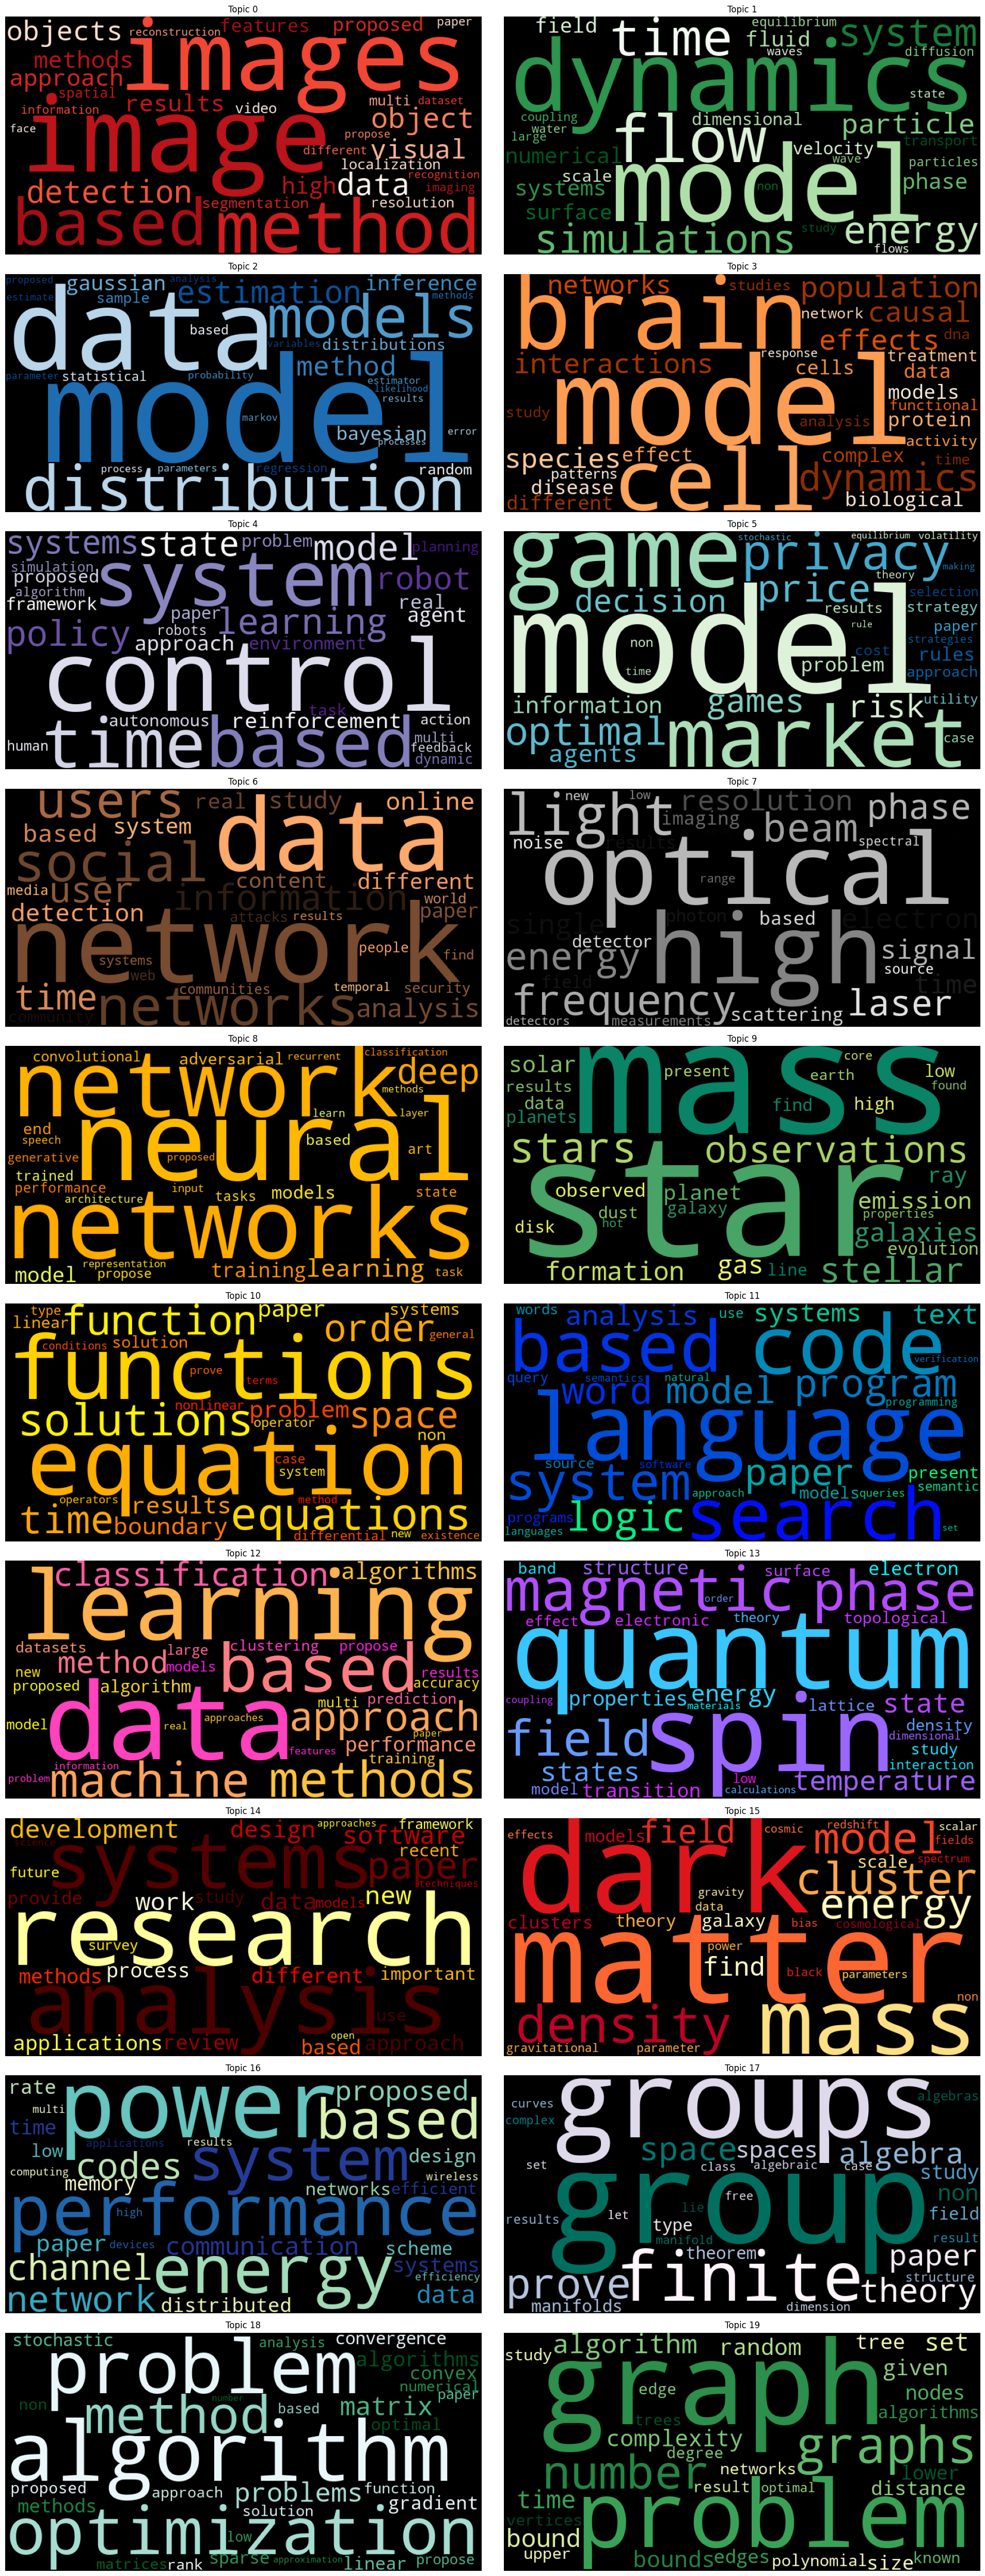

           Topic 0      Topic 1        Topic 2       Topic 3        Topic 4  \
0            image        model          model         model        control   
1           images     dynamics           data         brain         system   
2           method         flow   distribution          cell          based   
3            based         time         models      dynamics           time   
4        detection  simulations     estimation    population       learning   
5             data       system         method       effects          model   
6           object       energy       gaussian        causal         policy   
7          objects     particle      inference       species          state   
8           visual    numerical       bayesian  interactions        systems   
9          methods      systems  distributions      networks          robot   
10        approach        phase         sample    biological  reinforcement   
11         results        fluid         random      

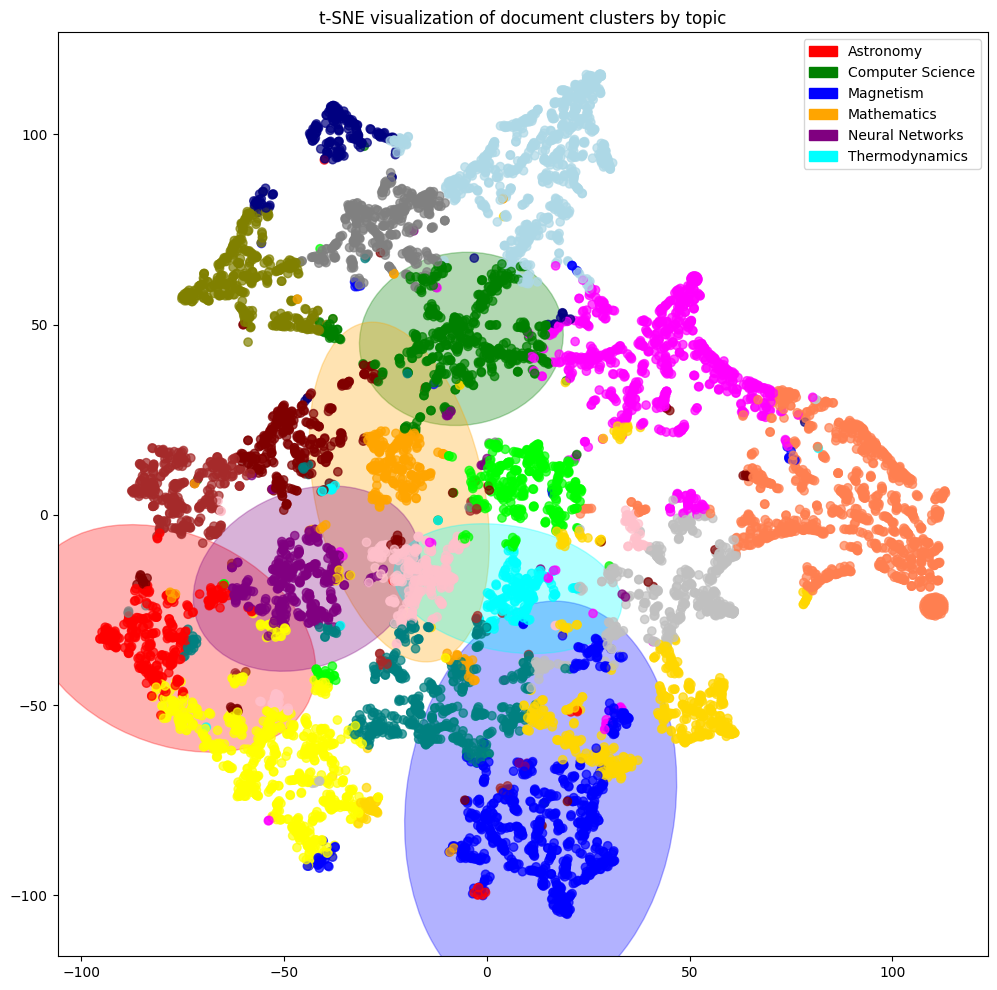


===== TOP DOCUMENTS PER TOPIC =====

Top documents for Topic 0:
     Topic  Probability                                           Document
0  Topic 0     0.977778  A New Pseudo-color Technique Based on Intensit...
1  Topic 0     0.973684  DSVO: Direct Stereo Visual Odometry   This pap...
2  Topic 0     0.879310  Volumetric Super-Resolution of Multispectral D...
3  Topic 0     0.872881  UAV Visual Teach and Repeat Using Only Semanti...
4  Topic 0     0.862595  Traffic Surveillance Camera Calibration by 3D ...
--------------------------------------------------------------------------------

Top documents for Topic 1:
     Topic  Probability                                           Document
0  Topic 1     0.993377  Cross-stream migration of a surfactant-laden d...
1  Topic 1     0.987342  The Mechanism behind Erosive Bursts in Porous ...
2  Topic 1     0.972222  Rheology of High-Capillary Number Flow in Poro...
3  Topic 1     0.942029  Rotating Rayleigh-Taylor turbulence   The turb...
4

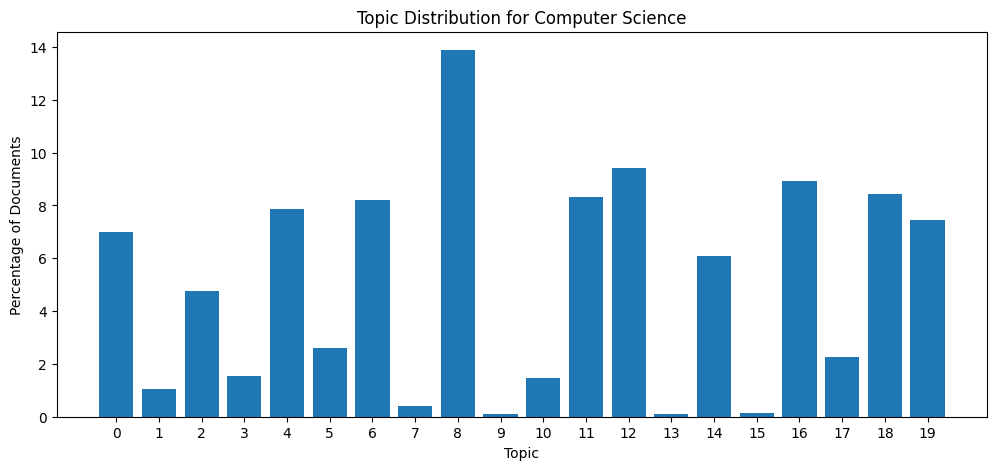


Computer Science is most associated with:
  Topic 8: 13.88%
  Topic 12: 9.43%
  Topic 16: 8.94%
  Topic 18: 8.42%
  Topic 11: 8.32%


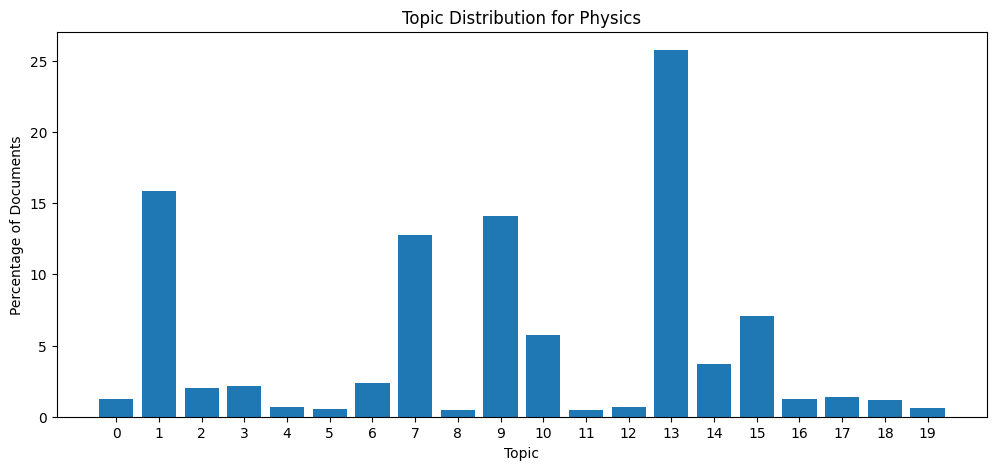


Physics is most associated with:
  Topic 13: 25.76%
  Topic 1: 15.86%
  Topic 9: 14.08%
  Topic 7: 12.79%
  Topic 15: 7.04%


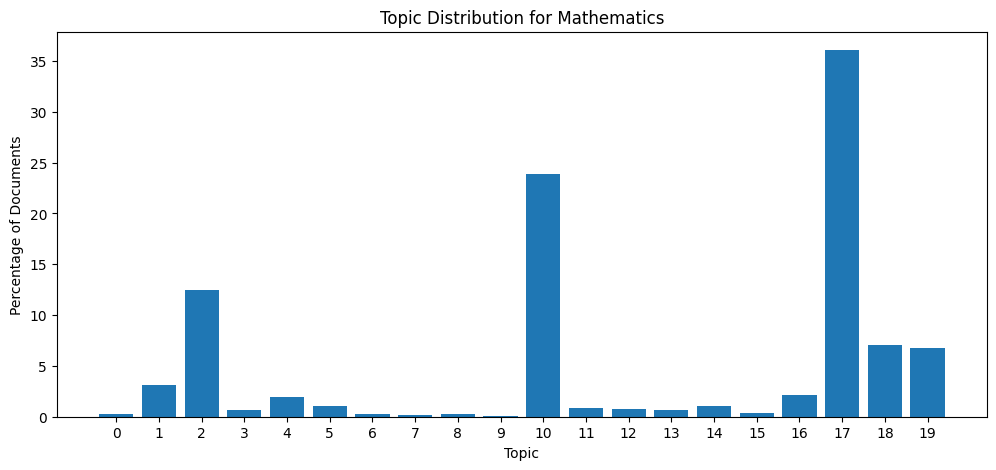


Mathematics is most associated with:
  Topic 17: 36.08%
  Topic 10: 23.91%
  Topic 2: 12.47%
  Topic 18: 7.07%
  Topic 19: 6.74%


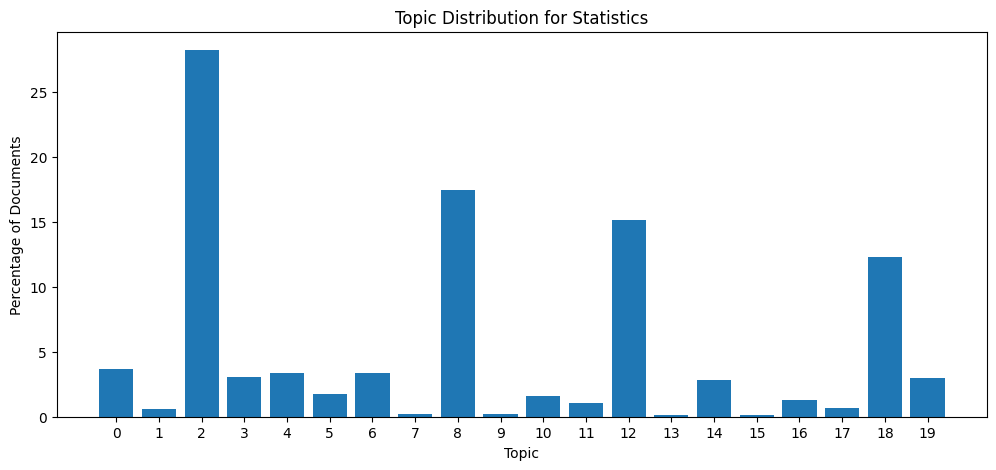


Statistics is most associated with:
  Topic 2: 28.24%
  Topic 8: 17.48%
  Topic 12: 15.16%
  Topic 18: 12.28%
  Topic 0: 3.64%


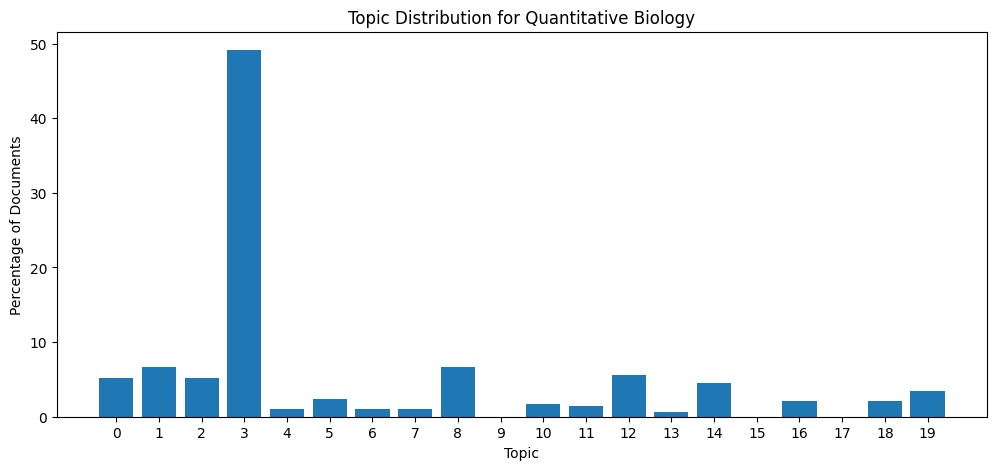


Quantitative Biology is most associated with:
  Topic 3: 49.13%
  Topic 1: 6.62%
  Topic 8: 6.62%
  Topic 12: 5.57%
  Topic 0: 5.23%


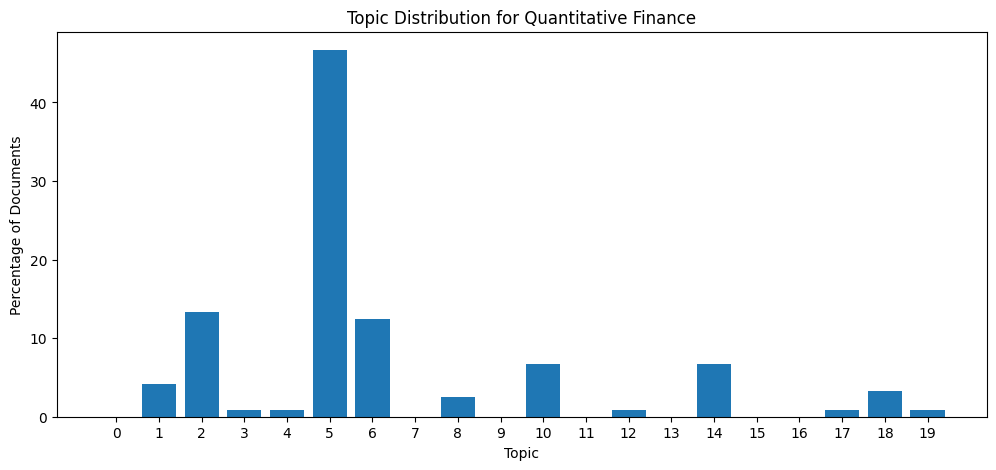


Quantitative Finance is most associated with:
  Topic 5: 46.67%
  Topic 2: 13.33%
  Topic 6: 12.50%
  Topic 14: 6.67%
  Topic 10: 6.67%

Training set perplexity: 1613.31
Test set size: 8989
Processing test data...
Number of documents after processing: 8989
Number of tokens after processing: 767050
Inferring topics for test documents...


100%|██████████| 50/50 [06:23<00:00,  7.67s/it]


Test set perplexity: 1747.21

===== TEST DOCUMENT CLUSTERS =====
Number of high confidence documents: 8301


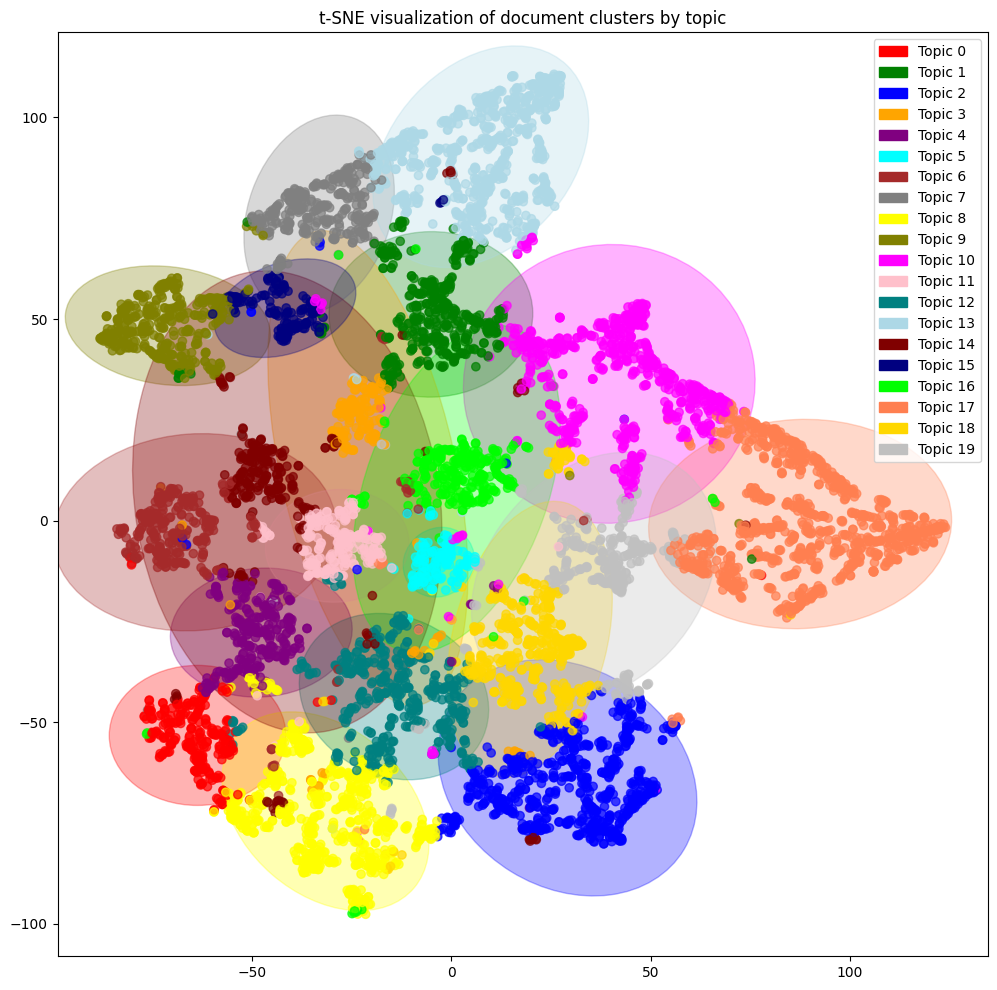


Test document topic distribution:

Document excerpt: Imaging Polarimeter for a Sub-MeV Gamma-Ray All-Sky Survey using an Electron-Tracking Compton Camera...
Top topics:
1. Topic 7 (probability: 0.5873)
2. Topic 9 (probability: 0.2460)
3. Topic 0 (probability: 0.1190)

Document excerpt: Improving Value-at-Risk prediction under model uncertainty   Several well-established benchmark pred...
Top topics:
1. Topic 2 (probability: 0.4302)
2. Topic 12 (probability: 0.2209)
3. Topic 5 (probability: 0.2093)

Document excerpt: Large Deviations and the Lukic Conjecture   We use the large deviation approach to sum rules pioneer...
Top topics:
1. Topic 17 (probability: 0.4419)
2. Topic 18 (probability: 0.2093)
3. Topic 5 (probability: 0.1860)

Document excerpt: A Differential Evaluation Markov Chain Monte Carlo algorithm for Bayesian Model Updating   The use o...
Top topics:
1. Topic 2 (probability: 0.6154)
2. Topic 14 (probability: 0.1368)
3. Topic 10 (probability: 0.1282)

Document excerpt: Iron 

In [64]:

if __name__ == "__main__":
    # Create model directory if it doesn't exist
    os.makedirs("model", exist_ok=True)
    
    # Paths to your CSV files
    train_csv_path = r"D:\From scratch series\LDA\train.csv"  
    test_csv_path = r"D:\From scratch series\LDA\test.csv"    
    
    main(train_csv_path, test_csv_path)

In [10]:
df

ID                                              TITLE  \
0          1        Reconstructing Subject-Specific Effect Maps   
1          2                 Rotation Invariance Neural Network   
2          3  Spherical polyharmonics and Poisson kernels fo...   
3          4  A finite element approximation for the stochas...   
4          5  Comparative study of Discrete Wavelet Transfor...   
...      ...                                                ...   
20967  20968  Contemporary machine learning: a guide for pra...   
20968  20969  Uniform diamond coatings on WC-Co hard alloy c...   
20969  20970  Analysing Soccer Games with Clustering and Con...   
20970  20971  On the Efficient Simulation of the Left-Tail o...   
20971  20972   Why optional stopping is a problem for Bayesians   

                                                ABSTRACT  Computer Science  \
0        Predictive models allow subject-specific inf...                 1   
1        Rotation invariance and translation invarian...                 1   
2        We introduce and develop the notion of spher...                 0   
3        The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4        Fourier-transform infra-red (FTIR) spectra o...                 1   
...                                                  ...               ...   
20967    Machine learning is finding increasingly bro...                 1   
20968    Polycrystalline diamond coatings have been g...                 0   
20969    We present a new approach for identifying si...                 1   
20970    The sum of Log-normal variates is encountere...                 0   
20971    Recently, optional stopping has been a subje...                 0   

       Physics  Mathematics  Statistics  Quantitative Biology  \
0            0            0           0                     0   
1            0            0           0                     0   
2            0            1           0                     0   
3            0            1           0                     0   
4            0            0           1                     0   
...        ...          ...         ...                   ...   
20967        1            0           0                     0   
20968        1            0           0                     0   
20969        0            0           0                     0   
20970        0            1           1                     0   
20971        0            1           1                     0   

       Quantitative Finance  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
20967                     0  
20968                     0  
20969                     0  
20970                     0  
20971                     0  

[20972 rows x 9 columns]